```{currentmodule} tskit
```

(sec_topological_analysis)=

# Topological analysis

The branching structure of a tree is known as the tree *topology*. Dealing with the
topological structure of trees is of key importance in dealing with genealogies
such as those encoded in the tree sequence structure.


(sec_topological_analysis_traversal)=

## Visiting nodes


(sec_topological_analysis_descending)=

### Descendant traversal

A basic thing to want to do is to visit all the nodes in a tree under a focal node
(i.e. the focal node and all its descendants). This can be done in various
*traversal orders*. The `tskit` library provides several methods to do this, such
as {meth}`Tree.nodes` in the {ref}`sec_python_api`. By default, this method
iterates over all the descendant nodes of the root(s) of the tree, and hence
visits all the tree's nodes:

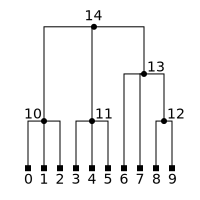

preorder:	 [14, 10, 0, 1, 2, 11, 3, 4, 5, 13, 6, 7, 12, 8, 9]
inorder:	 [0, 10, 1, 2, 14, 3, 11, 4, 5, 6, 13, 7, 8, 12, 9]
postorder:	 [0, 1, 2, 10, 3, 4, 5, 11, 6, 7, 8, 9, 12, 13, 14]


In [1]:
import tskit
from IPython.display import SVG, display

tree = tskit.Tree.generate_balanced(10, arity=3)
display(SVG(tree.draw_svg()))

for order in ["preorder", "inorder", "postorder"]:
    print(f"{order}:\t", list(tree.nodes(order=order)))

Providing a focal node ID allows us to traverse through that node's descendants.
For instance, here we visit node 13 and its descendants:

In [2]:
print("Nodes under node 13:", [u for u in tree.nodes(13)])

Nodes under node 13: [13, 6, 7, 12, 8, 9]


The node IDs returned by traversal methods allow us to to access node information.
Below, for example, we use the {meth}`Tree.num_children` method to find the number of
children (the "arity") of every non-leaf node, and take the average. Since the
specific ordering of descendant nodes is not important in this case, we can leave
it out (defaulting to preorder traversal, the most efficient order):

In [3]:
import numpy as np
av_arity = np.mean([tree.num_children(u) for u in tree.nodes() if not tree.is_leaf(u)])
print(f"Average arity of internal nodes: {av_arity}")

Average arity of internal nodes: 2.8


:::{note}
In `tskit`, a tree can have multiple {ref}`sec_data_model_tree_roots`, each with a
descendant topology.  However, for some algorithms, instead of traversing through
the descendants of each root of a tree in turn, it can be helpful to start at a
single node and traverse downwards through the entire genealogy. The
{ref}`virtual root<sec_data_model_tree_virtual_root>` is provided for this purpose.
:::

#### Array methods

The {meth}`Tree.nodes` iterator provides a convenient way of looping over descendant
node IDs, but it can be more efficient to deal with all the IDs at once, as a
single array of values. This can be combined with
{ref}`direct memory access<sec_python_api_trees_node_measures_array>` resulting in a
high performance approach. Here, for example, is an equivalent
array-based method to find the average arity of internal nodes, by counting
how many times a node is referenced as a parent:

In [4]:
parent_id, count = np.unique(tree.parent_array[tree.preorder()], return_counts=True)
print(f"Average arity is {count[parent_id != tskit.NULL].mean()}")

Average arity is 2.8


:::{seealso}
The {ref}`sec_analysing_trees` tutorial provides a number of additional examples
of tree traversal techniques, with different performance characteristics.
:::


(sec_topological_analysis_ascending)=

### Ascending traversal

For many applications it is useful to be able to traverse upwards from a node or set
of nodes, such as the leaves. We can do this by iterating over parents. Here, for
example, we traverse upwards from each of the samples in the tree:

In [5]:
for u in tree.samples():
    path = []
    v = u
    while v != tskit.NULL:
        path.append(v)
        v = tree.parent(v)
    print(u, "->", path)

0 -> [0, 10, 14]
1 -> [1, 10, 14]
2 -> [2, 10, 14]
3 -> [3, 11, 14]
4 -> [4, 11, 14]
5 -> [5, 11, 14]
6 -> [6, 13, 14]
7 -> [7, 13, 14]
8 -> [8, 12, 13, 14]
9 -> [9, 12, 13, 14]


:::{todo}
Indicate that this can be made performant using `numba`, and link out to a tutorial
on high performance methods including the `numba` approach.
:::


(sec_combinatorics)=

## Identifying and counting topologies

tskit uses a combinatorial approach to identify unique topologies of
rooted, leaf-labelled trees. It provides methods
for enumerating all possible tree topologies, as well as converting
back and forth between a tree and its position, or rank, in the
enumeration of all possible topologies.
These methods do not only apply to binary trees;
rather, they cover general, rooted trees without unary nodes.

```{list-table} 
* - {meth}`Tree.rank`
  - Return the rank of this tree.
* - {meth}`Tree.unrank`
  - Return a Tree given its rank and a number of leaves.
* - {func}`tskit.all_trees`
  - Return a generator over all leaf-labelled trees of n leaves.
* - {func}`tskit.all_tree_shapes`
  - Return a generator over all tree shapes of n leaves.
* - {func}`tskit.all_tree_labellings`
  - Return a generator over all labellings of the given tree's shape.
```

:::{note}
As the number of nodes increases, the number of different topologies rises
extremely rapidly (see its entry in the
[On-Line Encyclopedia of Integer Sequences](https://oeis.org/A000311)). This
combinatorial explosion is a major limitation in any analysis that attempts to
explore possible topologies. For example, although the {func}`tskit.all_trees`
function above will happily start generating topologies for (say) a tree of 50
leaves, the total number of possible topologies is over $6^81$, which is of
the same order as the number of atoms in the observable universe. Generating
all the topologies of a tree with anything much more than 10 tips is likely
to be impracticable.
:::


(sec_tree_ranks)=

### Interpreting Tree Ranks

To understand tree ranks we must look at how leaf-labelled tree topologies
are enumerated. For example, we can use {func}`tskit.all_trees`
to generate all possible topologies of three leaves:

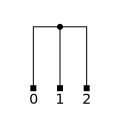

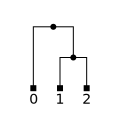

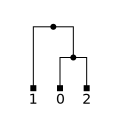

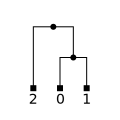

In [6]:
import tskit
from IPython.display import display, SVG

for t in tskit.all_trees(num_leaves=3):
    display(SVG(t.draw_svg(node_labels={0: 0, 1: 1, 2: 2}, order="tree", size=(120, 120))))

In this sequence, there exist two distinct tree shapes and each shape
can be labelled in at least one unique way. Given that topologies are
ordered first by their shape and then by their labelling, a tree
topology can be uniquely identified by

1. The shape of the tree
2. The labelling of the tree's shape

We can refer to the first tree in the above enumeration as the
first labelling of the first shape of trees with three leaves, or tree
$(0, 0)$. The second tree can be identified as the first labelling
of the second shape, or $(1, 0)$, and so on.
This pair of indexes for the shape and labelling of a tree is referred
to as the rank of the tree, and can be computed using the
{meth}`Tree.rank` method.

In [7]:
ranks = [t.rank() for t in tskit.all_trees(num_leaves=3)]
print("Ranks of 3-leaf trees:", ranks)

Ranks of 3-leaf trees: [Rank(shape=0, label=0), Rank(shape=1, label=0), Rank(shape=1, label=1), Rank(shape=1, label=2)]


```{note}
Ranks in combinatorics are typically natural numbers. However,
we refer to this tuple of shape and label rank as a rank because
it serves the same purpose of indexing trees in an enumeration.
```

For details on how shapes and labellings are ordered, see
{ref}`sec_enumerating_topologies`.

We can also reconstruct a leaf-labelled tree given its rank. This process
is known as unranking, and can be performed using the {meth}`Tree.unrank`
method.

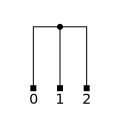

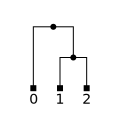

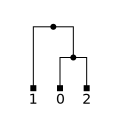

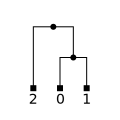

In [8]:
for rank in [(0, 0), (1, 0), (1, 1), (1, 2)]:
    t = tskit.Tree.unrank(num_leaves=3, rank=rank)
    display(SVG(t.draw_svg(node_labels={0: 0, 1: 1, 2: 2}, order="tree", size=(120, 120))))

#### Examples

One application of tree ranks is to count the different
leaf-labelled topologies in a tree sequence. Since the ranks
are just tuples, we can use a Python ``Counter`` to track them.
Here, we count and unrank the most frequently seen
topology in a tree sequence. For brevity, this example assumes
samples are synonymous with leaves.

Most frequent topology


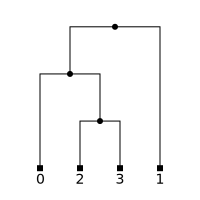

In [9]:
import collections
import msprime
# Simulate a tree sequence with 2 diploid individuals (i.e. 4 samples)
ts = msprime.sim_ancestry(2, sequence_length=1e8, recombination_rate=1e-7, random_seed=1)
rank_counts = collections.Counter(t.rank() for t in ts.trees())
most_freq_rank, count = rank_counts.most_common(1)[0]
most_freq_topology = tskit.Tree.unrank(ts.num_samples, most_freq_rank)
print("Most frequent topology")
display(SVG(most_freq_topology.draw_svg(node_labels={0: 0, 1: 1, 2: 2, 3: 3})))

(sec_enumerating_topologies)=

### Enumerating Topologies

This section expands briefly on the approach used to enumerate
tree topologies that serves as the basis for {meth}`Tree.rank`
and {meth}`Tree.unrank`.
To enumerate all rooted, leaf-labelled tree topologies, we first
formulate a system of ordering and enumerating tree shapes. Then
we define an enumeration of labellings given an arbitrary tree shape.

#### Enumerating Tree Shapes

Starting with $n = 1$, we see that the only shape for a tree
with a single leaf is a single root leaf. A tree with $n > 1$
leaves can be obtained by joining at least two trees whose number of
leaves sum to $n$.
This maps very closely to the concept of integer partitions.
Each tree shape of $n$ leaves can be represented by taking a
nondecreasing integer partition of $n$ (elements of the partition
are sorted in nondecreasing order) and recursively partitioning its
elements. The order in which we select partitions of $n$ is
determined by the efficient
[rule_asc](http://jeromekelleher.net/generating-integer-partitions.html)
algorithm for generating them.

All tree shapes with four leaves, and the partitions that generate
them, are:

```{image} _static/four_leaf_tree_shapes.png
:alt: All four-leaf tree shapes and their generating partitions
```

Note that the middle column reflects all tree shapes of three leaves
in the right subtree!

`*` This excludes the partition $[n]$, since this would create a unary node
and trees with unary nodes are inumerable (and potentially infinite).

```{note}
Using nondecreasing integer partitions enforces a
*canonical orientation* on the tree shapes, where children under a node are
ordered by the number of leaves below them.
This is important because it prevents us from repeating trees that are
topologically the same but whose children are ordered differently.
```

#### Labelling Tree Shapes

Tree shapes are useful in and of themselves, but we can use the enumeration
formulated above to go further and assign labels to the leaves of each shape.

Say we are given a tree $T$ with $n$ leaves, whose left-most
subtree, $T_l$, has `k` leaves. For each of the $n \choose k$
ways to select labels to assign to $T_l$, we produce a unique labelling
of $T$. This process of choosing labels is repeated for the other
children of $T$ and then recursively for the subtrees.

Looking back to the example from {ref}`sec_tree_ranks`, we can see
the second tree shape, where the tree is a strictly bifucating tree of
three leaves, can be labelled in 3 different unique ways.

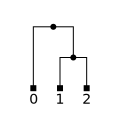

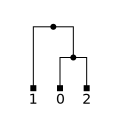

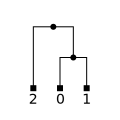

In [10]:
second_tree = tskit.Tree.unrank(num_leaves=3, rank=(1, 0))
for t in tskit.all_tree_labellings(second_tree):
    display(SVG(t.draw_svg(node_labels={0: 0, 1: 1, 2: 2}, order="tree", size=(120, 120))))

The order of the tree labellings is a direct result of the way in which
combinations of labels are chosen. The implementation in tskit uses a
standard lexicographic ordering to choose labels. See how the trees
are sorted by the order in which the left leaf's label was chosen.

```{note}
There is a caveat here regarding symmetry, similar to that of repeating
tree shapes. Symmetrical trees run the risk of creating redundant labellings
if all combinations of labels were exhausted. To prevent redundant labellings
we impose a *canonical labelling*. In the case of two symmetrical subtrees,
the left subtree must receive the minimum label from the label set. Notice
how this is the case in the right subtrees above.
```

These two enumerations create a complete ordering of topologies where trees are
ordered first by size (number of leaves), then by shape, then by their minimum
label. It is this canonical order that enables efficient ranking and unranking
of topologies.